<a href="https://colab.research.google.com/github/adityapathania22/Text-anaysis-and-machine-learning-with-spark/blob/main/BDSN_END_TERM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Aditya Pathania) <br>
[aditya pathania](https://www.linkedin.com/in/aditya-pathania-06b989164/)<br>

# Problem Statement:

#### In this notebook, we try to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. The goal of the notebook is not to get too fancy with the choice of the Algorithms but its more on how can you use Spark to achieve or at least try to achieve what you could do using scikit-learn and pandas. The dataset can be downloaded from the Kaggle competition page.According to the competition page there are three distinct author initials we have already been provided with a mapping of these initials to the actual author which is as follows:


#### EAP - Edgar Allen Poe
#### HPL - HP Lovecraft
#### MWS - Mary Shelley

#Setting up spark for python

In [ ]:
!apt update > /dev/null

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q http://apache.osuosl.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

In [ ]:
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 198 kB 58.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d671765d12c757a3fd59c819441c84f4edfa357804cf6e9d157adfb4e1c6530e
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


# Create Spark Session

In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local[*]").config('spark.ui.port','4050').getOrCreate()

In [ ]:
ap=spark.sparkContext

In [ ]:
import re
import nltk
import string
import unicodedata
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession, SQLContext

import pyspark.sql.functions as F
from pyspark.sql.types import StructField, StructType, ArrayType, IntegerType, StringType

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Word2Vec, StringIndexer, IndexToString, VectorAssembler

In [ ]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

sns.set(context='notebook', style='whitegrid', rc={"figure.figsize": (18,4)})

In [ ]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)

# Load The Data From Files Into Dataframes

In [ ]:
rnd_seed = 42

In [ ]:
DATA_PATH = '/content/train.csv'

In [ ]:
DATA_PATH_test='/content/test.csv'

In [ ]:
test_df=spark.read.csv(f'{DATA_PATH_test}', sep=',', escape='"', header=True)

In [ ]:
train_df = spark.read.csv(f'{DATA_PATH}', sep=',', escape='"', header=True)

In [ ]:
train_df.cache()

DataFrame[id: string, text: string, author: string]

In [ ]:
train_df.show(5, truncate=50)

+-------+--------------------------------------------------+------+
|     id|                                              text|author|
+-------+--------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ...|   EAP|
|id17569|It never once occurred to me that the fumbling ...|   HPL|
|id11008|In his left hand was a gold snuff box, from whi...|   EAP|
|id27763|How lovely is spring As we looked from Windsor ...|   MWS|
|id12958|Finding nothing else, not even gold, the Superi...|   HPL|
+-------+--------------------------------------------------+------+
only showing top 5 rows



## How many Unique Authors

In [ ]:
train_df.select('author').distinct().show()

+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+



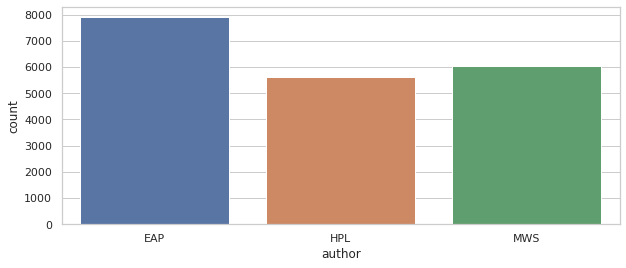

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(x='author', data=train_df.select('author').toPandas());

#### As we saw in the problem statement we had 3 authors , we can see EAP has a maximum count of text and HPL the lowest

#  Understanding the Tokenizer and Other NLP Transformer

### In this section we will build a basic word tokenizer and see how can we generate features for Machine Learning.

In [ ]:
# Basic sentence tokenizer
tokenizer_tf = Tokenizer(inputCol="text", outputCol="tokens")

In [ ]:
tokens_df = tokenizer_tf.transform(train_df)

In [ ]:
tokens_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>]

In [ ]:
tokens_df.show(5, truncate=45)

+-------+---------------------------------------------+------+---------------------------------------------+
|     id|                                         text|author|                                       tokens|
+-------+---------------------------------------------+------+---------------------------------------------+
|id26305|This process, however, afforded me no mean...|   EAP|[this, process,, however,, afforded, me, n...|
|id17569|It never once occurred to me that the fumb...|   HPL|[it, never, once, occurred, to, me, that, ...|
|id11008|In his left hand was a gold snuff box, fro...|   EAP|[in, his, left, hand, was, a, gold, snuff,...|
|id27763|How lovely is spring As we looked from Win...|   MWS|[how, lovely, is, spring, as, we, looked, ...|
|id12958|Finding nothing else, not even gold, the S...|   HPL|[finding, nothing, else,, not, even, gold,...|
+-------+---------------------------------------------+------+---------------------------------------------+
only showing top 5 

In [ ]:
tokens_df.select('tokens').take(5)

[Row(tokens=['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']),
 Row(tokens=['it', 'never', 'once', 'occurred', 'to', 'me', 'that', 'the', 'fumbling', 'might', 'be', 'a', 'mere', 'mistake.']),
 Row(tokens=['in', 'his', 'left', 'hand', 'was', 'a', 'gold', 'snuff', 'box,', 'from', 'which,', 'as', 'he', 'capered', 'down', 'the', 'hill,', 'cutting', 'all', 'manner', 'of', 'fantastic', 'steps,', 'he', 'took', 'snuff', 'incessantly', 'with', 'an', 'air', 'of', 'the', 'greatest', 'possible', 'self', 'satisfaction.']),
 Row(tokens=['how', 'lovely', 'is', 'spring', 'as', 'we', 'looked', 'from', 'windsor', 'terrace', 'on', 'the', 'sixteen', 'fertile', 'counties', 'spread', 'beneath,', 'speckled'

In [ ]:
tokens_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



### our main goal hear was to create a token that contain the main words that have been maximumly used the author and these tokens are used in the word cloud to see the usage of words as well

# WordClouds to visualise each author's work

##### Let us visualize the words used by each author by plotting a WordCloud. A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here instead of dealing with an actual book or text, our words can simply be taken from the column tokens.

#### We need to apply a series of Spark functions to get all the tokens for a given author:Each row in the Dataframe is a token array. So, when we group by each author, we collect tokens as an array of arrays using collect_list function for each author. And, then finally flatten out the array of arrays into one array using flatten function and collect them into the all_tokens column.

In [ ]:
tokens_by_author_df = (tokens_df
                      .groupBy('author')
                      .agg(F.flatten(
                            F.collect_list('tokens')).alias('all_tokens')))
tokens_by_author_df.cache()

DataFrame[author: string, all_tokens: array<string>]

In [ ]:
tokens_by_author_df.show(truncate=75)

+------+---------------------------------------------------------------------------+
|author|                                                                 all_tokens|
+------+---------------------------------------------------------------------------+
|   MWS|[how, lovely, is, spring, as, we, looked, from, windsor, terrace, on, th...|
|   HPL|[it, never, once, occurred, to, me, that, the, fumbling, might, be, a, m...|
|   EAP|[this, process,, however,, afforded, me, no, means, of, ascertaining, th...|
+------+---------------------------------------------------------------------------+



In [ ]:
# verify that the array has been flattened; each element off `all_tokens` should be a string
tokens_by_author_df.printSchema()

root
 |-- author: string (nullable = true)
 |-- all_tokens: array (nullable = false)
 |    |-- element: string (containsNull = true)



In [ ]:
# verify that the array has been flattened; extract out the first token for each author
tokens_by_author_df.select('author', F.element_at('all_tokens', 1).alias('first_token')).show()

+------+-----------+
|author|first_token|
+------+-----------+
|   MWS|        how|
|   HPL|         it|
|   EAP|       this|
+------+-----------+



In [ ]:
hpl_tokens = tokens_by_author_df.filter(F.col('author') == 'HPL').select('all_tokens').take(1)
mws_tokens = tokens_by_author_df.filter(F.col('author') == 'MWS').select('all_tokens').take(1)
eap_tokens = tokens_by_author_df.filter(F.col('author') == 'EAP').select('all_tokens').take(1)

In [ ]:
# quick type checking
type(eap_tokens), len(eap_tokens), type(eap_tokens[0]), type(eap_tokens[0].all_tokens)

(list, 1, pyspark.sql.types.Row, list)

In [ ]:
# plot the word cloud from the tokens
from wordcloud import WordCloud, STOPWORDS
def plot_word_cloud(tokens, title):
    plt.figure(figsize=(14, 12))
    wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
    wc.generate(" ".join(tokens))
    plt.title(title, fontsize=18)
    # plt.imshow(wc.recolor(colormap='Pastel1_r', random_state=23), alpha=0.98)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=23), alpha=0.98)
    plt.axis('off');

#### we do this by generating a library called STOPWORDS , that automatically generate stop words per the classes /author , and each word is assigned as a token for that 

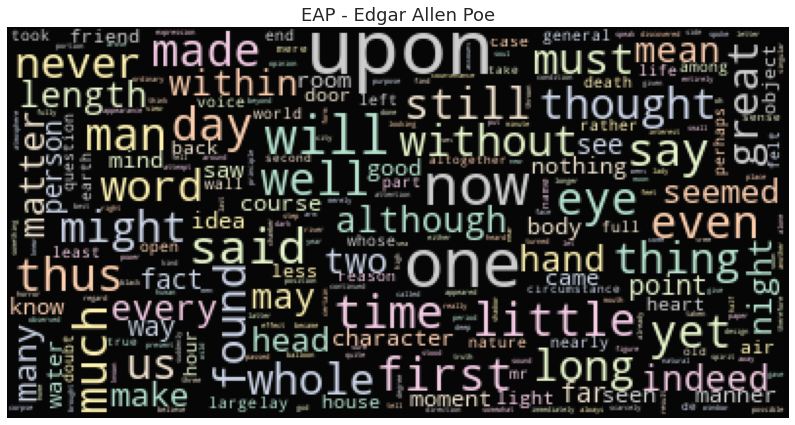

In [ ]:
plot_word_cloud(eap_tokens[0].all_tokens, "EAP - Edgar Allen Poe")

#### EAP - Edgar Allen Poe works revolved around tales of mystery and the grisly and the grim. We can see the usage of body, head, heart in his works.

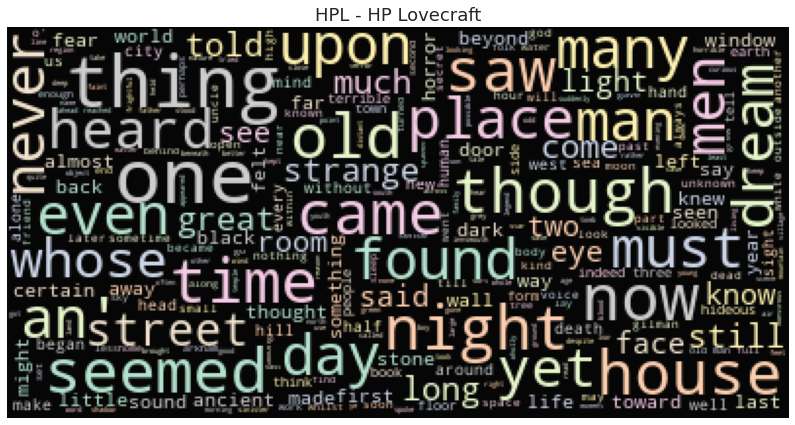

In [ ]:
plot_word_cloud(hpl_tokens[0].all_tokens, "HPL - HP Lovecraft")

#### HPL - HP Lovecraft's works revolved around fictional mythology. We can see the usage of dream, eye, strange in his works.

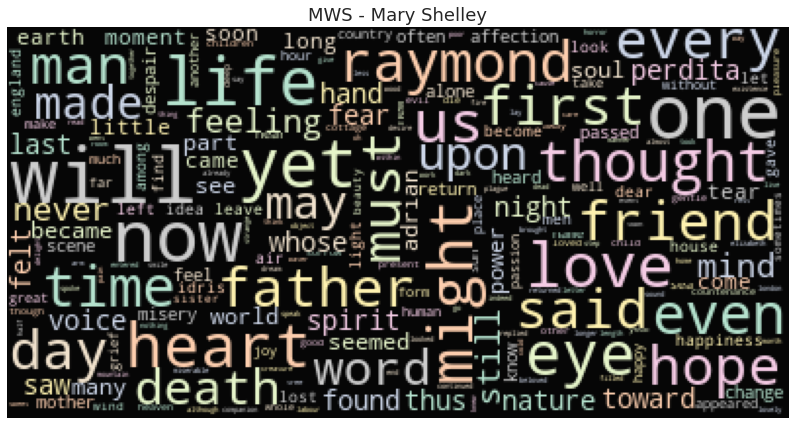

In [ ]:
plot_word_cloud(mws_tokens[0].all_tokens, "MWS - Mary Shelley")

#### MWS - Mary Shelley seemed to be a versatile author. I do not find any distinctive choice of words.

# Counting the tokens into hashed feature

In [ ]:
# Count the words in a document
hashing_tf = HashingTF(inputCol="tokens", outputCol="hashed_features")

In [ ]:
hashing_tf_test=HashingTF(inputCol="tokens", outputCol="hashed_features")

In [ ]:
hashed_df = hashing_tf.transform(tokens_df)

In [ ]:
hashed_df_test = hashing_tf_test.transform(tokens_df)

In [ ]:
hashed_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector]

In [ ]:
hashed_df.show(10, truncate=30)

+-------+------------------------------+------+------------------------------+------------------------------+
|     id|                          text|author|                        tokens|               hashed_features|
+-------+------------------------------+------+------------------------------+------------------------------+
|id26305|This process, however, affo...|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|
|id17569|It never once occurred to m...|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|
|id11008|In his left hand was a gold...|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|
|id27763|How lovely is spring As we ...|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|
|id12958|Finding nothing else, not e...|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|
|id22965|A youth passed in solitude,...|   MWS|[a, youth, passed, in, soli...|(262144,[7075,13938,15494,1...|
|id09674|T

In [ ]:
hashed_df_test.show(10, truncate=30)

+-------+------------------------------+------+------------------------------+------------------------------+
|     id|                          text|author|                        tokens|               hashed_features|
+-------+------------------------------+------+------------------------------+------------------------------+
|id26305|This process, however, affo...|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|
|id17569|It never once occurred to m...|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|
|id11008|In his left hand was a gold...|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|
|id27763|How lovely is spring As we ...|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|
|id12958|Finding nothing else, not e...|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|
|id22965|A youth passed in solitude,...|   MWS|[a, youth, passed, in, soli...|(262144,[7075,13938,15494,1...|
|id09674|T

In [ ]:
hashed_df.take(1)

[Row(id='id26305', text='This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.', author='EAP', tokens=['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.'], hashed_features=SparseVector(262144, {239: 1.0, 19036: 2.0, 27576: 1.0, 34188: 1.0, 42924: 1.0, 50001: 1.0, 51910: 1.0, 69205: 1.0, 80158: 1.0, 82544: 1.0, 88590: 1.0, 89717: 1.0, 91767: 1.0, 95889: 4.0, 98726: 1.0, 108541: 1.0, 117491: 1.0, 118667: 1.0, 124786: 1.0, 140315: 1.0, 148880: 1.0, 158069: 1.0, 160249: 1.0, 162916: 1.0, 183339: 1.0, 186312: 1.0, 1985

#### this helped to count the words for each token vector created and become useful for machine learning implementation

# Creating a vectorizer for the whole text token to use it with the mathematics of machine learning

In [ ]:
# Build the idf model and transform the original token frequencies into their tf-idf counterparts
idf_tf = IDF(inputCol="hashed_features", outputCol="tfidf_features")

In [ ]:
idf_model = idf_tf.fit(hashed_df)

In [ ]:
idf_model_test = idf_tf.fit(hashed_df_test)

In [ ]:
tfidf_df = idf_model.transform(hashed_df)

In [ ]:
tfidf_df_test = idf_model.transform(hashed_df_test)

#### we will use the tfidf vectorizer , that uses hashed features of count created and turn it into a vector of words for machine learning implementation

In [ ]:
tfidf_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector]

In [ ]:
tfidf_df.select('id', 'author', 'tokens', 'hashed_features', 'tfidf_features').show(5, truncate=30)

+-------+------+------------------------------+------------------------------+------------------------------+
|     id|author|                        tokens|               hashed_features|                tfidf_features|
+-------+------+------------------------------+------------------------------+------------------------------+
|id26305|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|(262144,[239,19036,27576,34...|
|id17569|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|(262144,[24284,27576,30950,...|
|id11008|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|(262144,[25217,28338,42404,...|
|id27763|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|(262144,[19245,29423,42404,...|
|id12958|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|(262144,[2128,32983,33917,3...|
+-------+------+------------------------------+------------------------------+------------------------------+
only showi

In [ ]:
tfidf_df_test.select('id', 'author', 'tokens', 'hashed_features', 'tfidf_features').show(5, truncate=30)

+-------+------+------------------------------+------------------------------+------------------------------+
|     id|author|                        tokens|               hashed_features|                tfidf_features|
+-------+------+------------------------------+------------------------------+------------------------------+
|id26305|   EAP|[this, process,, however,, ...|(262144,[239,19036,27576,34...|(262144,[239,19036,27576,34...|
|id17569|   HPL|[it, never, once, occurred,...|(262144,[24284,27576,30950,...|(262144,[24284,27576,30950,...|
|id11008|   EAP|[in, his, left, hand, was, ...|(262144,[25217,28338,42404,...|(262144,[25217,28338,42404,...|
|id27763|   MWS|[how, lovely, is, spring, a...|(262144,[19245,29423,42404,...|(262144,[19245,29423,42404,...|
|id12958|   HPL|[finding, nothing, else,, n...|(262144,[2128,32983,33917,3...|(262144,[2128,32983,33917,3...|
+-------+------+------------------------------+------------------------------+------------------------------+
only showi

In [ ]:
tfidf_df.select('tfidf_features').take(1)

[Row(tfidf_features=SparseVector(262144, {239: 8.496, 19036: 2.0973, 27576: 0.818, 34188: 5.8047, 42924: 9.1891, 50001: 2.4363, 51910: 9.1891, 69205: 7.5797, 80158: 9.1891, 82544: 6.7912, 88590: 6.6634, 89717: 4.3025, 91767: 6.3269, 95889: 1.259, 98726: 6.1211, 108541: 2.1534, 117491: 2.7183, 118667: 6.3269, 124786: 4.1852, 140315: 2.881, 148880: 4.865, 158069: 4.8388, 160249: 3.9934, 162916: 3.6304, 183339: 4.013, 186312: 2.594, 198589: 1.8636, 209518: 4.9406, 219087: 1.614, 219915: 0.5915, 221027: 7.8028, 240944: 1.6174, 256468: 3.5437, 257069: 8.0905, 261675: 5.0782}))]

#Create advanced Tokenizer

In this section we will build a custom word tokenizer where we:

Create the word tokens (lemmatize words, remove stop words and punctuations, strip off html and digits)
Count the number of punctuations in a sentence (can be a useful feature)
Count the number of words in a sentence (can be a useful feature)

In [ ]:
# Tokenize sentence (lemmatize words, remove stop words and punctuations, strip off html and digits)
# Returns a struct of tokens, tokens count, punctuation count
def lemmatize(text):
    """
    param: sentence
    return: tokens, tokens count, punctuation count
    """
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    list_punct=set(string.punctuation)
    
    punct_count = sum([1 for ch in text if ch in list_punct])
    
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    # remove urls
    text = re.sub(r'https?.+|[^(a-zA-Z)(0-9)\s]', ' ', text)
    # remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    words = text.split()
    # remove stopwords and strings of length <= 2
    words = [wnl.lemmatize(word) for word in words if word not in stopwords and len(word) > 2]
    word_count = len(words)
    
    return words, word_count, punct_count

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatize("#trump:a,wOrds.c      .dd. 123 https://asdasdf, http://asdasdf,")

(['trump', 'word'], 2, 14)

In [ ]:
assert (['trump', 'word'], 2, 14) == lemmatize("#trump:a,wOrds.c      .dd. 123 https://asdasdf, http://asdasdf,")

In [ ]:
lemmatize("""This process, however, afforded me no means of ascertaining the dimensions of my dungeon;
          as I might make its circuit, and return to the point whence I set out, without being aware of the fact;
          so perfectly uniform seemed the wall.
          """)

(['process',
  'however',
  'afforded',
  'mean',
  'ascertaining',
  'dimension',
  'dungeon',
  'might',
  'make',
  'circuit',
  'return',
  'point',
  'whence',
  'set',
  'without',
  'aware',
  'fact',
  'perfectly',
  'uniform',
  'seemed',
  'wall'],
 21,
 7)

# Preparing Features for Machine Learning

#### we will use the lematized vector of words , and create a label for each user into our y dataset

In [ ]:
# check the original individual feature columns
tfidf_df.take(1)

[Row(id='id26305', text='This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.', author='EAP', tokens=['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'i', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.'], hashed_features=SparseVector(262144, {239: 1.0, 19036: 2.0, 27576: 1.0, 34188: 1.0, 42924: 1.0, 50001: 1.0, 51910: 1.0, 69205: 1.0, 80158: 1.0, 82544: 1.0, 88590: 1.0, 89717: 1.0, 91767: 1.0, 95889: 4.0, 98726: 1.0, 108541: 1.0, 117491: 1.0, 118667: 1.0, 124786: 1.0, 140315: 1.0, 148880: 1.0, 158069: 1.0, 160249: 1.0, 162916: 1.0, 183339: 1.0, 186312: 1.0, 1985

In [ ]:
label_indexer = StringIndexer(inputCol = "author", outputCol = "label")

In [ ]:
label_indexer_model = label_indexer.fit(tfidf_df)

In [ ]:
labeled_train_df = label_indexer_model.transform(tfidf_df)

In [ ]:
labeled_test_df=label_indexer_model.transform(tfidf_df_test)

In [ ]:
labeled_train_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector, label: double]

In [ ]:
labeled_train_df.select('text', 'author', 'tfidf_features', 'label').show(10, truncate=50)

+--------------------------------------------------+------+--------------------------------------------------+-----+
|                                              text|author|                                    tfidf_features|label|
+--------------------------------------------------+------+--------------------------------------------------+-----+
|This process, however, afforded me no means of ...|   EAP|(262144,[239,19036,27576,34188,42924,50001,5191...|  0.0|
|It never once occurred to me that the fumbling ...|   HPL|(262144,[24284,27576,30950,39275,48448,50001,95...|  2.0|
|In his left hand was a gold snuff box, from whi...|   EAP|(262144,[25217,28338,42404,48648,49120,55559,57...|  0.0|
|How lovely is spring As we looked from Windsor ...|   MWS|(262144,[19245,29423,42404,62400,67416,95889,10...|  1.0|
|Finding nothing else, not even gold, the Superi...|   HPL|(262144,[2128,32983,33917,37673,49120,64760,723...|  2.0|
|A youth passed in solitude, my best years spent...|   MWS|(2621

#### now that we have transformed our features to tfidf tranformed features , we will check and count and split equally for each users , this is more over like a feature selection, this is to be done to avoid biasness of the model

In [ ]:
(labeled_train_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_train_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  0.0| 7900| 0.4|
|  1.0| 6044|0.31|
|  2.0| 5635|0.29|
+-----+-----+----+



#### specify the exact fraction desired from each key as a dictionary

In [ ]:
fractions = {0: 0.25, 1: 0.25, 2: 0.25}

In [ ]:
labeled_validation_df = labeled_train_df.stat.sampleBy('label', fractions, seed=rnd_seed).cache()

#### create the validation set with 25% of the entire data and same distribution of author labels

In [ ]:
labeled_train_df = labeled_train_df.subtract(labeled_validation_df).cache()

#### subtract the validation set from the original training set to get 75% of the entire data and same distribution of author label

In [ ]:
labeled_train_df.cache()
labeled_validation_df.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector, label: double]

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector, label: double]

In [ ]:
total_count = labeled_train_df.count() + labeled_validation_df.count()

train_pctg = labeled_train_df.count() / total_count
valid_pctg = labeled_validation_df.count() / total_count 

In [ ]:
print('Ratio train:valid',train_pctg,':',valid_pctg)

Ratio train:valid 0.7480602464628023 : 0.2519397535371976


In [ ]:
(labeled_train_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_train_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  0.0| 3288| 0.4|
|  1.0| 2546|0.31|
|  2.0| 2361|0.29|
+-----+-----+----+



In [ ]:
(labeled_validation_df
 .groupBy('label')
 .count()
 .withColumn('%age', F.round(F.col('count') / labeled_validation_df.count(), 2))
 .show())

+-----+-----+----+
|label|count|%age|
+-----+-----+----+
|  0.0| 1119|0.41|
|  1.0|  864|0.31|
|  2.0|  777|0.28|
+-----+-----+----+



#### we see that out labels have equal percentage in train and validation set 

# Machine Learning model

In [ ]:
lr = LogisticRegression(featuresCol='tfidf_features', 
                        labelCol='label', 
                        predictionCol='prediction',
                        probabilityCol='probability',
                        maxIter=20, 
                        regParam=0.3, 
                        elasticNetParam=0)

In [ ]:
lrModel = lr.fit(labeled_train_df)

In [ ]:
train_preds_labels = lrModel.transform(labeled_train_df)
validation_preds_labels = lrModel.transform(labeled_validation_df)

In [ ]:
train_preds_labels.cache()
validation_preds_labels.cache()

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

DataFrame[id: string, text: string, author: string, tokens: array<string>, hashed_features: vector, tfidf_features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
train_preds_labels.select('text', 'author', 'tfidf_features', 'label', 'probability', 'prediction').show(5)

+--------------------+------+--------------------+-----+--------------------+----------+
|                text|author|      tfidf_features|label|         probability|prediction|
+--------------------+------+--------------------+-----+--------------------+----------+
|At such times, al...|   EAP|(262144,[10077,19...|  0.0|[0.88508120206136...|       0.0|
|The great clock o...|   EAP|(262144,[10228,95...|  0.0|[0.85464774389614...|       0.0|
|We kept track of ...|   HPL|(262144,[2622,394...|  2.0|[0.17520778912928...|       2.0|
|There are six can...|   EAP|(262144,[46923,58...|  0.0|[0.82076268911299...|       0.0|
|It was firmly sec...|   EAP|(262144,[11694,30...|  0.0|[0.88749179149987...|       0.0|
+--------------------+------+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [ ]:
train_preds_labels.select("probability", "prediction").take(1)

[Row(probability=DenseVector([0.8851, 0.079, 0.0359]), prediction=0.0)]

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')

In [ ]:
train_f1_score = evaluator.evaluate(train_preds_labels)
validation_f1_score = evaluator.evaluate(validation_preds_labels)

In [ ]:
print('train_f1_score',train_f1_score,'validation_f1_score',validation_f1_score)

train_f1_score 0.9964611893909074 validation_f1_score 0.7677756780042333


### as we see that our predictions are good for the model , the probability of each text is calculated as well using our training model, the model performed good in validation and provided the f1 score of 76 % in the test 
### model being logistic regression , performed well to classify our feautes with 3 classes